<a href="https://colab.research.google.com/github/UDICatNCHU/PyTorch-Tutorial/blob/master/Lesson_9_BERT_for_QG_on_DRCD_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 確認 GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6e10400d-d443-2979-a124-ee93ddcbe38a)


### Mount 雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Masked LM Task


### 載入相關套件

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 2.9MB/s 
     |████████████████████████████████| 2.9MB 16.9MB/s 
     |████████████████████████████████| 890kB 42.6MB/s 
     |████████████████████████████████| 1.1MB 40.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7a0c8f275687b1c0bd906e8b2df89d1efb54ac1b5037da64462002d3b44e1736
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizerFast, BertForMaskedLM
import torch
from pprint import pprint

### 使用 bert-base-chinese 預訓練模型進行 Masked LM Task 預測

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = BertForMaskedLM.from_pretrained('bert-base-chinese', return_dict=True)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sentence = "今[MASK]天[MASK]是大[MASK]陽"

inputs_encodings = tokenizer(sentence, return_tensors="pt")
pprint(inputs_encodings)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[ 101,  791,  103, 1921,  103, 3221, 1920,  103, 7382,  102]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [ ]:
outputs = model(**inputs_encodings)
print(outputs['logits'])

tensor([[[ -7.7514,  -7.6983,  -7.7034,  ...,  -6.5356,  -6.5790,  -6.5821],
         [ -7.9448,  -7.8761,  -7.7864,  ...,  -6.6594,  -6.8355,  -6.5145],
         [ -8.5947,  -8.9173,  -8.7153,  ...,  -6.4466,  -9.1011,  -8.6727],
         ...,
         [ -7.5196,  -7.5137,  -8.0660,  ...,  -7.6359, -11.0394,  -7.4551],
         [-10.0508,  -9.9053,  -9.6828,  ...,  -7.5788,  -7.8342,  -7.8304],
         [ -8.3801,  -8.2615,  -8.2933,  ...,  -5.6104,  -5.5805,  -5.4206]]],
       grad_fn=<AddBackward0>)


In [ ]:
print(outputs['logits'].shape)

torch.Size([1, 10, 21128])


In [ ]:
for i, token in enumerate(inputs_encodings[0].ids):
  if token == 103 : # [MASK] token id = 103
    predict = torch.argmax(outputs['logits'][0][i])
    predict_token = tokenizer.convert_ids_to_tokens(predict.item())
    print(predict_token + '\n')
    sentence = sentence.replace('[MASK]', predict_token)

print(sentence)

天

氣

太

今天天氣是大太陽


## A Recurrent BERT-based Model for Question Generation

In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/

/content/drive/My Drive/Colab Notebooks


### 下載 DRCD 資料集

In [ ]:
!mkdir /content/drive/My\ Drive/Colab\ Notebooks/QG\ on\ drcd
%cd /content/drive/My\ Drive/Colab\ Notebooks/QG\ on\ drcd

/content/drive/My Drive/Colab Notebooks/QG on drcd


In [ ]:
!wget https://github.com/DRCKnowledgeTeam/DRCD/blob/master/DRCD_training.json?raw=True -O train.json
!wget https://github.com/DRCKnowledgeTeam/DRCD/blob/master/DRCD_dev.json?raw=True -O dev.json

--2020-11-12 05:52:29--  https://github.com/DRCKnowledgeTeam/DRCD/blob/master/DRCD_training.json?raw=True
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DRCKnowledgeTeam/DRCD/raw/master/DRCD_training.json [following]
--2020-11-12 05:52:29--  https://github.com/DRCKnowledgeTeam/DRCD/raw/master/DRCD_training.json
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DRCKnowledgeTeam/DRCD/master/DRCD_training.json [following]
--2020-11-12 05:52:29--  https://raw.githubusercontent.com/DRCKnowledgeTeam/DRCD/master/DRCD_training.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP re

#### DRCD 資料格式
台達閱讀理解資料集 Delta Reading Comprehension Dataset (DRCD) 屬於通用領域繁體中文機器閱讀理解資料集。
本資料集期望成為適用於遷移學習之標準中文閱讀理解資料集。
本資料集從2,108篇維基條目中整理出10,014篇段落，並從段落中標註出30,000多個問題


For more information please refer to Paper: https://arxiv.org/abs/1806.00920

### Data format 資料格式

- version : <String> 資料集版本
- data : <Array>
  - title : <String> : 文章標題
  - id : <String> : 文章編號
  - paragraphs : <Array>
    - id : <String> : 文章編號_段落編號
    - context : <String> : 段落內容
    - qas : <Array>
      - question : <String> : 問題內容
      - id :<String> : 文章編號_段落編號_問題編號
      - answers : <Arrays>
        - answer_start : <int> text在文中位置
        - id : <String> : "1"表示為人工標註的答案，"2"以上為人工答題的答案
        - text : <string> : 答案內容

**References:**

- [DRCD](https://github.com/DRCKnowledgeTeam/DRCD)


In [ ]:
import json
from pprint import pprint
with open('train.json') as file:
  train_data = json.load(file)
for ele in train_data['data']:
  pprint(ele)
  break

{'id': '1001',
 'paragraphs': [{'context': '2010年引進的廣州快速公交運輸系統，屬世界第二大快速公交系統，日常載客量可達100萬人次，高峰時期每小時單向客流高達26900人次，僅次於波哥大的快速交通系統，平均每10秒鐘就有一輛巴士，每輛巴士單向行駛350小時。包括橋樑在內的站台是世界最長的州快速公交運輸系統站台，長達260米。目前廣州市區的計程車和公共汽車主要使用液化石油氣作燃料，部分公共汽車更使用油電、氣電混合動力技術。2012年底開始投放液化天然氣燃料的公共汽車，2014年6月開始投放液化天然氣插電式混合動力公共汽車，以取代液化石油氣公共汽車。2007年1月16日，廣州市政府全面禁止在市區內駕駛摩托車。違反禁令的機動車將會予以沒收。廣州市交通局聲稱禁令的施行，使得交通擁擠問題和車禍大幅減少。廣州白雲國際機場位於白雲區與花都區交界，2004年8月5日正式投入運營，屬中國交通情況第二繁忙的機場。該機場取代了原先位於市中心的無法滿足日益增長航空需求的舊機場。目前機場有三條飛機跑道，成為國內第三個擁有三跑道的民航機場。比鄰近的香港國際機場第三跑道預計的2023年落成早8年。',
                 'id': '1001-10',
                 'qas': [{'answers': [{'answer_start': 84,
                                       'id': '1',
                                       'text': '10秒鐘'}],
                          'id': '1001-10-1',
                          'question': '廣州的快速公交運輸系統每多久就會有一輛巴士？'},
                         {'answers': [{'answer_start': 256,
                                       'id': '1',
                                       'text': '2007年1月16日'}],

### 載入相關套件

In [ ]:
!pip install transformers

In [ ]:
import json
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from transformers import (AdamW, BertForMaskedLM, BertTokenizer,
                          Trainer, TrainingArguments)

### 使用 bert-base-chinese 預訓練模型進行訓練

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertForMaskedLM.from_pretrained('bert-base-chinese', return_dict=True)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 讀取資料（整理出資料中的 context、question、answer）並製作 Sequential 訓練資料

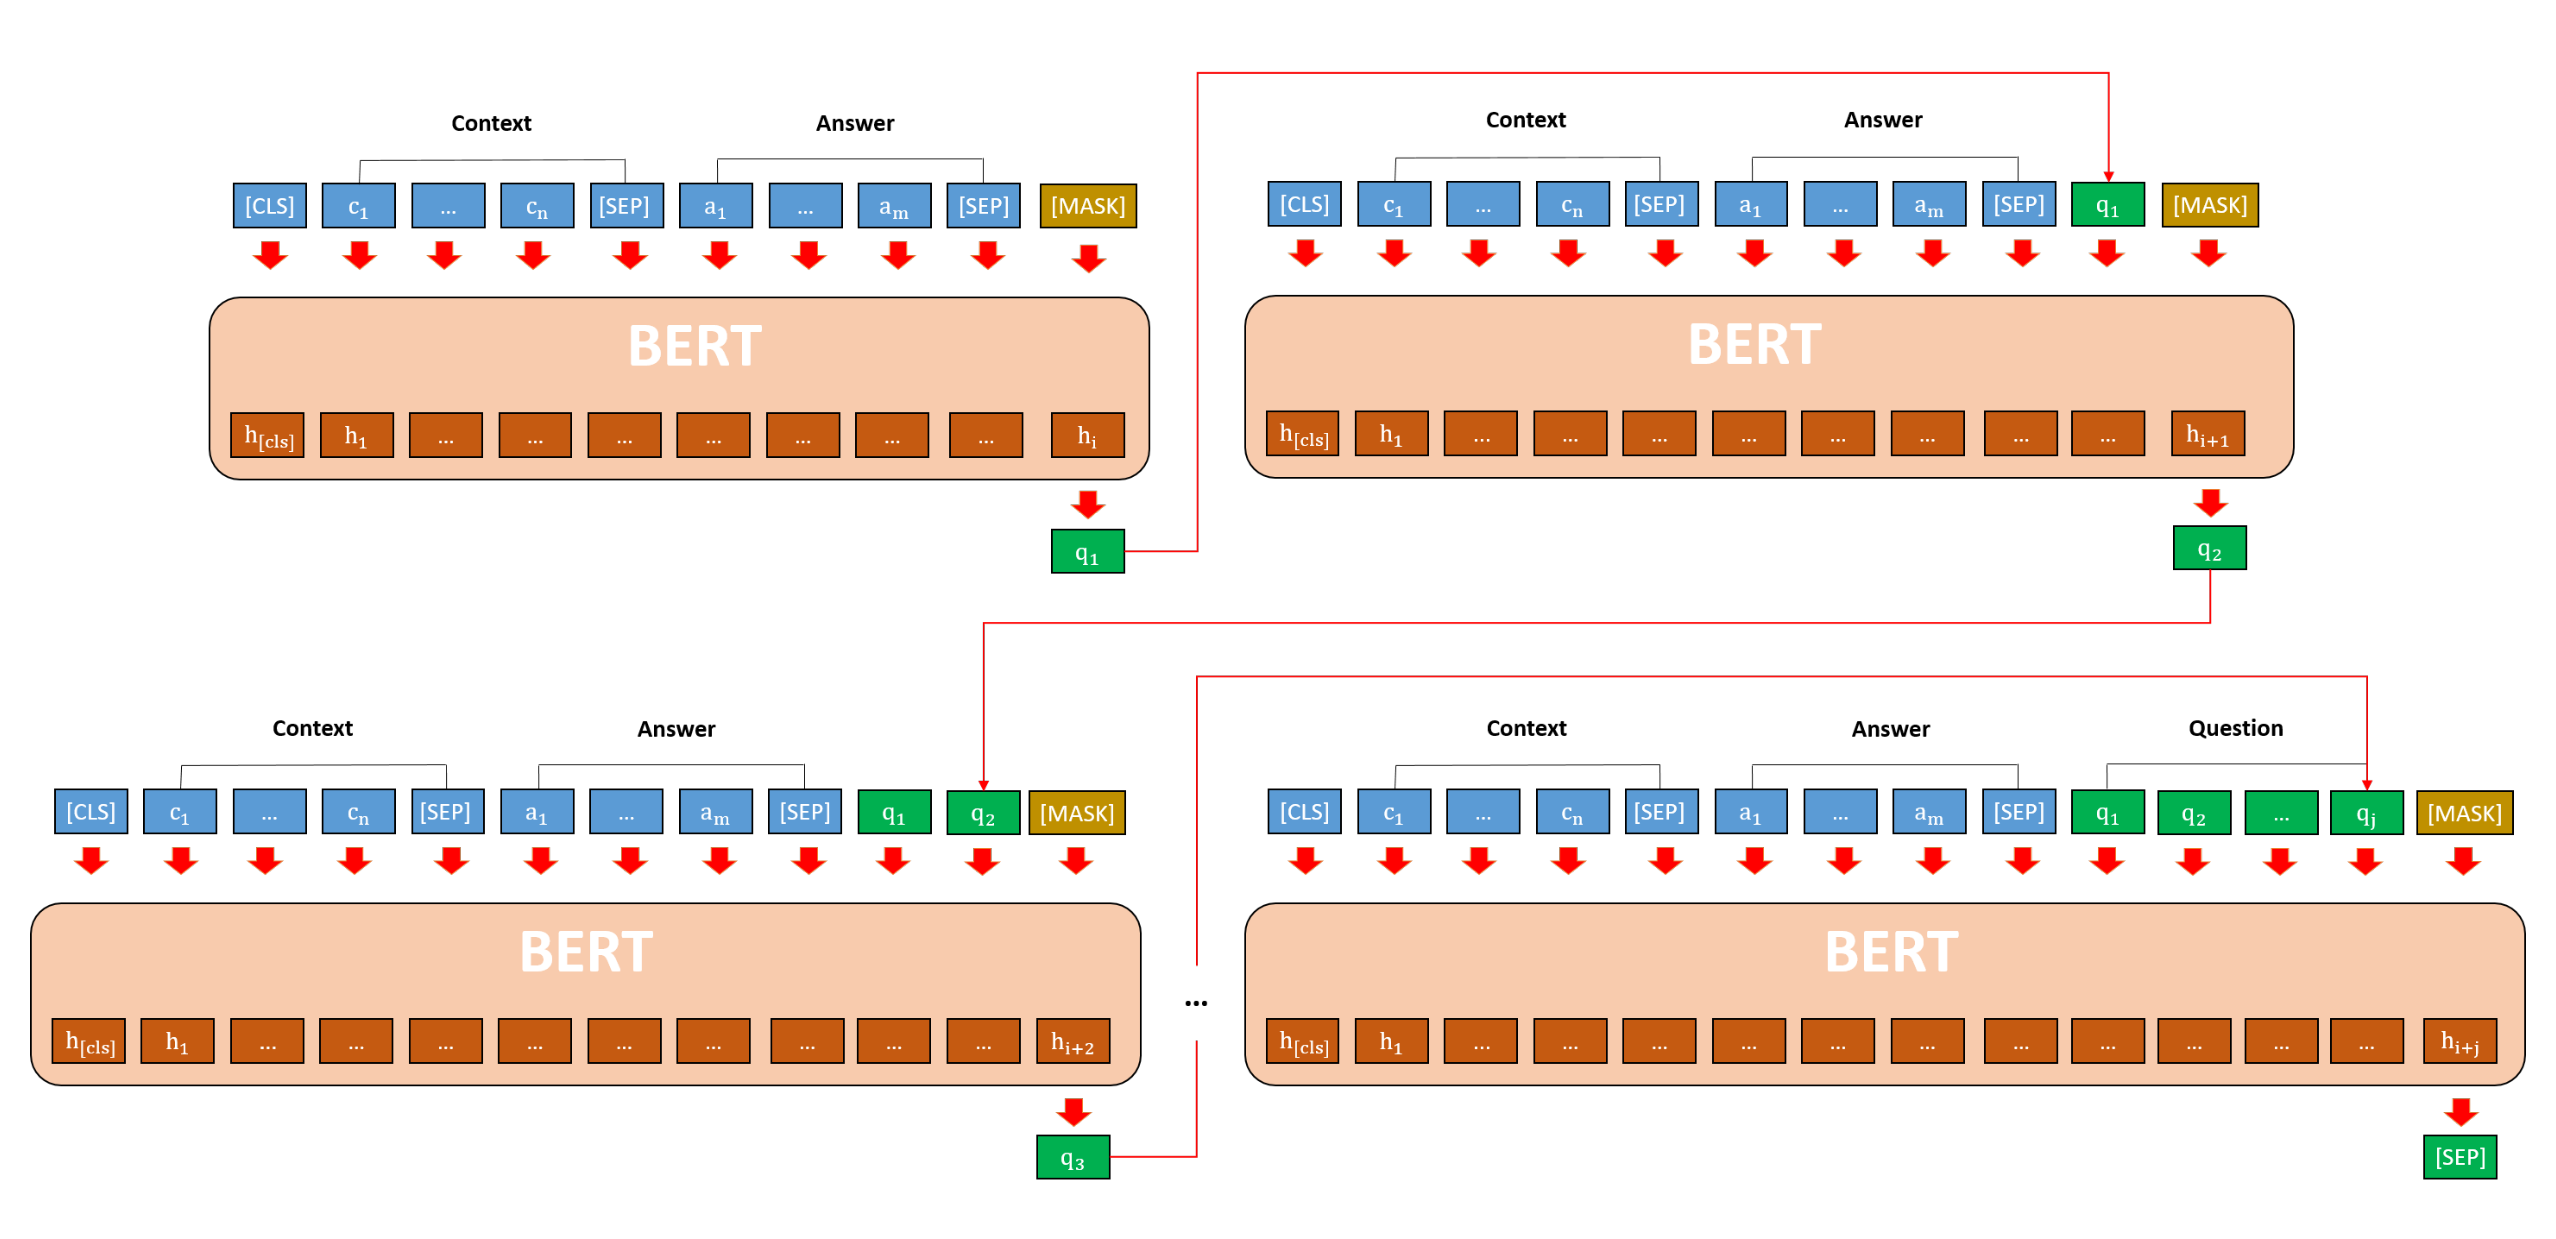

In [ ]:
def read_drcd(path, num_limit = -1):  # num_limit 限制資料筆數（-1則使用全部資料）
  path = Path(path)
  with open(path, 'rb') as f:
      drcd_dict = json.load(f)

  contexts = []
  answers = []
  input_QWords = []
  label_QWords = []
  for group in drcd_dict['data']:
    for passage in group['paragraphs']:
      context = passage['context']
      for qa in passage['qas']:
        question = qa['question']
        for answer in qa['answers']:
          input_QWord = '[MASK]'
          for question_word in question:
            contexts.append(context)
            answers.append(answer['text'])
            input_QWords.append(input_QWord)
            label_QWords.append(question_word)           
            input_QWord = input_QWord.replace('[MASK]','') + question_word + '[MASK]'

          contexts.append(context)
          answers.append(answer['text'])
          input_QWords.append(input_QWord)
          label_QWords.append('[SEP]')

      if num_limit != -1 and len(contexts) > num_limit:
        return contexts, answers, input_QWords, label_QWords

  return contexts, answers, input_QWords, label_QWords

train_contexts, train_answers, train_input_QWords, train_label_QWords = read_drcd('./train.json', num_limit = 50000)
val_contexts, val_answers, val_input_QWords, val_label_QWords = read_drcd('./dev.json', num_limit = 5000)

print('train_data　筆數：' ,len(train_contexts))
print('val_data　筆數：', len(val_contexts))

train_data　筆數： 50009
val_data　筆數： 5008


In [ ]:
for i, (contexts, answers, input_QWords, label_QWords) in enumerate(zip(train_contexts, train_answers, train_input_QWords, train_label_QWords)):
  print('iter', i)
  print('context', contexts)
  print('answer', answers)
  print('input_QWords', input_QWords)     
  print('label_QWord', label_QWords)     
  print('-'*10)
  if i == 22:
    break

iter 0
context 2010年引進的廣州快速公交運輸系統，屬世界第二大快速公交系統，日常載客量可達100萬人次，高峰時期每小時單向客流高達26900人次，僅次於波哥大的快速交通系統，平均每10秒鐘就有一輛巴士，每輛巴士單向行駛350小時。包括橋樑在內的站台是世界最長的州快速公交運輸系統站台，長達260米。目前廣州市區的計程車和公共汽車主要使用液化石油氣作燃料，部分公共汽車更使用油電、氣電混合動力技術。2012年底開始投放液化天然氣燃料的公共汽車，2014年6月開始投放液化天然氣插電式混合動力公共汽車，以取代液化石油氣公共汽車。2007年1月16日，廣州市政府全面禁止在市區內駕駛摩托車。違反禁令的機動車將會予以沒收。廣州市交通局聲稱禁令的施行，使得交通擁擠問題和車禍大幅減少。廣州白雲國際機場位於白雲區與花都區交界，2004年8月5日正式投入運營，屬中國交通情況第二繁忙的機場。該機場取代了原先位於市中心的無法滿足日益增長航空需求的舊機場。目前機場有三條飛機跑道，成為國內第三個擁有三跑道的民航機場。比鄰近的香港國際機場第三跑道預計的2023年落成早8年。
answer 10秒鐘
input_QWords [MASK]
label_QWord 廣
----------
iter 1
context 2010年引進的廣州快速公交運輸系統，屬世界第二大快速公交系統，日常載客量可達100萬人次，高峰時期每小時單向客流高達26900人次，僅次於波哥大的快速交通系統，平均每10秒鐘就有一輛巴士，每輛巴士單向行駛350小時。包括橋樑在內的站台是世界最長的州快速公交運輸系統站台，長達260米。目前廣州市區的計程車和公共汽車主要使用液化石油氣作燃料，部分公共汽車更使用油電、氣電混合動力技術。2012年底開始投放液化天然氣燃料的公共汽車，2014年6月開始投放液化天然氣插電式混合動力公共汽車，以取代液化石油氣公共汽車。2007年1月16日，廣州市政府全面禁止在市區內駕駛摩托車。違反禁令的機動車將會予以沒收。廣州市交通局聲稱禁令的施行，使得交通擁擠問題和車禍大幅減少。廣州白雲國際機場位於白雲區與花都區交界，2004年8月5日正式投入運營，屬中國交通情況第二繁忙的機場。該機場取代了原先位於市中心的無法滿足日益增長航空需求的舊機場。目前機場有三條飛機跑道，成為國內第三個擁有三跑道的民航機

### 訓練資料製作成模型 input 格式

In [ ]:
class InputFeatures(object):
  def __init__(self, input_ids, token_type_ids, attention_mask, labels, label_indexs):
    self.input_ids = input_ids
    self.token_type_ids = token_type_ids
    self.attention_mask = attention_mask
    self.labels = labels
    self.label_indexs = label_indexs

In [ ]:
def convert_data_to_features(contexts, answers, input_QWords, label_QWords=None):
  features = {'input_ids':[], 'token_type_ids':[], 'attention_mask':[], 'labels':[], 'label_indexs':[]}

#   for i, (context, answer, input_QWord) in notebook.tqdm(enumerate(zip(contexts, answers, input_QWords))):
  for i, (context, answer, input_QWord) in enumerate(zip(contexts, answers, input_QWords)):
    try:
        context_tokens = tokenizer.tokenize(context)
        answer_tokens = tokenizer.tokenize(answer)
        input_QWord_tokens = tokenizer.tokenize(input_QWord)

        if len(context_tokens) > max_context_length:
          context_tokens = context_tokens[0:max_context_length] 

        if len(answer_tokens) > max_answer_length:
          answer_tokens = answer_tokens[0:max_answer_length]  

        input_tokens = ['[CLS]'] + context_tokens + ['[SEP]'] + answer_tokens + ['[SEP]'] + input_QWord_tokens
        input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
        if len(input_ids) > 512:continue

        token_type_ids = []
        type_flag = 0
        attention_mask = []

        for id in input_ids:
          attention_mask.append(1)
          token_type_ids.append(type_flag)
          if id == 102: #[SEP]
            if type_flag == 0:
              type_flag = 1
            else:
              type_flag = 0
        label_indexs = len(input_ids) - 1

        while len(input_ids) < max_seq_length:
          input_ids.append(0)
          token_type_ids.append(0)
          attention_mask.append(0)

        assert len(input_ids) == max_seq_length
        assert len(token_type_ids) == max_seq_length
        assert len(attention_mask) == max_seq_length

        labels=[]
        labels = [-100] * max_seq_length # -100 index = padding token
        assert len(labels) == max_seq_length 

        if label_QWords != None:
          label_QWord_tokens = tokenizer.tokenize(label_QWords[i])
          labels[label_indexs] = tokenizer.convert_tokens_to_ids(label_QWord_tokens)[0]
        
    except Exception as e:
        print(e)
        continue
        
    features['input_ids'].append(input_ids)
    features['token_type_ids'].append(token_type_ids)
    features['attention_mask'].append(attention_mask)        
    features['labels'].append(labels)    
    features['label_indexs'].append(label_indexs)
        
  return InputFeatures(input_ids = features['input_ids'],
            token_type_ids = features['token_type_ids'],
            attention_mask = features['attention_mask'],
            labels = features['labels'],
            label_indexs = features['label_indexs'])

In [ ]:
max_seq_length = 512
max_context_length = 450 
max_question_length = 42
max_answer_length = 16

train_features = convert_data_to_features(train_contexts, train_answers, train_input_QWords, train_label_QWords)
val_features = convert_data_to_features(val_contexts, val_answers, val_input_QWords, val_label_QWords)

print(len(train_features.input_ids))
print(len(val_features.input_ids))

50009
5008


### 定義 Dataset，並轉換成 tensor 格式

In [ ]:
class DrcdDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
            
    def __getitem__(self, idx):

        return {'input_ids': torch.tensor(self.encodings.input_ids[idx]),
            'token_type_ids': torch.tensor(self.encodings.token_type_ids[idx]),
            'attention_mask': torch.tensor(self.encodings.attention_mask[idx]),
            'labels': torch.tensor(self.encodings.labels[idx])} 

    def __getdict__(self):

        return {'input_ids': torch.tensor(self.encodings.input_ids),
            'token_type_ids': torch.tensor(self.encodings.token_type_ids),
            'attention_mask': torch.tensor(self.encodings.attention_mask),
            'labels': torch.tensor(self.encodings.labels)}

    def __len__(self):
        return len(self.encodings.input_ids)
    
    def label_index(self, idx):
        return self.encodings.label_indexs[idx]

In [ ]:
train_dataset = DrcdDataset(train_features)
val_dataset = DrcdDataset(val_features)

In [ ]:
print(train_dataset[0])

{'input_ids': tensor([  101,  8166,  2399,  2471,  6868,  4638,  2451,  2336,  2571,  6862,
         1062,   769,  6880,  6745,  5143,  5186,  8024,  2253,   686,  4518,
         5018,   753,  1920,  2571,  6862,  1062,   769,  5143,  5186,  8024,
         3189,  2382,  6734,  2145,  7030,  1377,  6888,  8135,  5857,   782,
         3613,  8024,  7770,  2292,  3229,  3309,  3680,  2207,  3229,  1606,
         1403,  2145,  3837,  7770,  6888, 11023,  8279,   782,  3613,  8024,
         1006,  3613,  3176,  3797,  1520,  1920,  4638,  2571,  6862,   769,
         6858,  5143,  5186,  8024,  2398,  1772,  3680,  8108,  4907,  7132,
         2218,  3300,   671,  6739,  2349,  1894,  8024,  3680,  6739,  2349,
         1894,  1606,  1403,  6121,  7691,  8612,  2207,  3229,   511,  1259,
         2886,  3578,  3558,  1762,  1058,  4638,  4991,  1378,  3221,   686,
         4518,  3297,  7269,  4638,  2336,  2571,  6862,  1062,   769,  6880,
         6745,  5143,  5186,  4991,  1378,  8024, 

### Train

In [ ]:
# 設定訓練參數
training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,    
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
)

#使用 bert-base-chinese 預訓練模型
model = BertForMaskedLM.from_pretrained("bert-base-chinese")

#將參數與資料丟入 trainer 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#開始訓練模型
%%time
trainer.train()

Step,Training Loss
500,2.598964
1000,2.269672
1500,2.192252
2000,2.072558
2500,2.044734
3000,2.040284
3500,1.932313
4000,1.922712
4500,1.841834
5000,1.704084


CPU times: user 1h 50min 27s, sys: 1h 8min 1s, total: 2h 58min 29s
Wall time: 2h 59min 28s


TrainOutput(global_step=6252, training_loss=1.980929540047185)

In [ ]:
#儲存模型

trainer.save_model("./results")

### Inference

In [ ]:
from torch.utils.data import DataLoader
from transformers import (AdamW, BertForMaskedLM, BertTokenizer, BertConfig,
                          Trainer, TrainingArguments)

import torch
import torch.nn.functional as F
import textwrap

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
config = BertConfig.from_pretrained("./results/config.json") 
model = BertForMaskedLM.from_pretrained("./results/pytorch_model.bin", config=config)

device = torch.device("cuda")
model.to(device)

In [ ]:
def QG(model, contexts, answers):
    question = ''
    input_QWords = '[MASK]'
    while(1):
        inputs = DrcdDataset(convert_data_to_features([contexts], [answers], [input_QWords]))
        
        # trainer = Trainer(
            # model=model
        # )

        # logits = trainer.predict(inputs).predictions
        # logits = trainer.evaluate(inputs)
        # print(logits)
        # input()
        label_index = inputs.label_index(0)
        inputs = inputs.__getdict__()
        inputs['input_ids'] = inputs['input_ids'].to(device)
        inputs['token_type_ids'] = inputs['token_type_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        inputs['labels'] = inputs['labels'].to(device)

        loss, logits = model(**inputs)

        logits_SM = F.log_softmax(torch.tensor(logits[0][label_index]),0)

        predicted_index = torch.argmax(logits_SM).item()
        predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

        if predicted_token == '[SEP]':
            break
        else:
            input_QWords = input_QWords.replace('[MASK]','') + predicted_token + '[MASK]'
        question += predicted_token

    return question.replace('[MASK]','')

In [ ]:
wrapper = textwrap.TextWrapper(width=80) 

contexts = "《西遊記》，又稱《西遊釋厄傳》，是中國古代第一部浪漫主義章回體長篇神魔小說，中國《四大名著》之一、《四大奇書》之一。成書於16世紀明朝中葉，一般認為作者是明朝的吳承恩。"
answers = ["浪漫主義", "吳承恩", "16世紀"]

print("Context: " + wrapper.fill(contexts) + '\n')

for answer in answers:
    question = QG(model, contexts, answer)
    print(f"Answer: {answer}")
    print(f"Question: {question}")
    print("\n")

Context: 《西遊記》，又稱《西遊釋厄傳》，是中國古代第一部浪漫主義章回體長篇神魔小說，中國《四大名著》之一、《四大奇書》之一。成書於16世紀明朝中葉，一般認為作者是明朝的
吳承恩。



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Answer: 浪漫主義
Question: 西遊記是哪種主義的作品？


Answer: 吳承恩
Question: 《西遊記》的作者為？


Answer: 16世紀
Question: 《西遊記》於何時成書？


